In [1]:
%cd C:\Users\yukir\Documents\GitHub\Sign_Recognition\py

from basic_preprocessing import *
from deeplearning_check import *
from machine_learning import *

gpu_check()
set_global_determinism(seed=SEED)

import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import glob
import math
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import Image

import tensorflow as tf
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import keras

#cv
import cv2
import math
from PIL import Image
import math
from scipy import ndimage
import argparse
import imutils
import xml.etree.ElementTree as ET

import random 
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')

import matplotlib.image as mpimg
from matplotlib import font_manager, rc
rc('font',family="consolas")
plt.rcParams["font.family"]="consolas" #plt 한글꺠짐
plt.rcParams["font.family"]="Arial" #외국어꺠짐
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호 출력 설정
plt.rc('figure', figsize=(10,8))

sns.set(font="consolas", 
        rc={"axes.unicode_minus":False},style='darkgrid')

%cd C:\Users\yukir\Documents\Monicas_workspace\Knee

C:\Users\yukir\Documents\GitHub\Sign_Recognition\py


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15428539136843859861
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 353353472910157058
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2140507393400947281
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14850211919385581630
physical_device_desc: "device: XLA_GPU device"
]
tf 2.2.0
keras 2.3.0-tf
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
C:\Users\yukir\Documents\Monicas_workspace\Knee


In [2]:
# process시각화 및 손실함수

def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()
    fig = plt.gcf()
    fig.savefig("../03_model_visualization/"+model_name+".jpg")
    plt.close(fig)

### DATA

In [3]:
train_dir = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Knee\\dataset\\new_mask_vgg\\train"
test_dir = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Knee\\dataset\\new_mask_vgg\\test"
val_dir = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Knee\\dataset\\new_mask_vgg\\val"

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
from keras import Input
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(224,224), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(224, 224), color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=16, target_size=(224, 224), color_mode='rgb')

input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

Found 1500 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 285 images belonging to 5 classes.


In [6]:
from tqdm import tqdm

In [7]:
train_images =[]
train_labels = []

for directory_path in tqdm (glob.glob(train_dir+'//*')):
    label = directory_path.split('\\')[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        # img = cv2.resize(img, (244, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(len(train_images))
print(len(train_labels))

100%|██████████| 5/5 [00:04<00:00,  1.12it/s]

1500
1500


In [8]:
# Capture test/validation data and labels into respective lists

SIZE = 224  #Resize images

#Capture training data and labels into respective lists
test_images = []
test_labels = [] 

for directory_path in tqdm(glob.glob(val_dir+'//*')):
    label = directory_path.split("\\")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

#Convert lists to arrays        
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(len(test_images))
print(len(test_labels))

100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

500
500


In [9]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
#딥러닝으로 들어갈때는 원핫으로 들어가야함

from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [14]:
#Load model wothout classifier/fully connected layers
SIZE = 224
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train = features #This is our X input to RF

In [16]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 100, n_jobs = 1, random_state = 1337)

# Train the model on training data
RF_model.fit(X_train, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
# print(prediction_RF)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)
# print(prediction_RF)

In [17]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.516


              precision    recall  f1-score   support

           0       0.48      0.60      0.53       100
           1       0.37      0.34      0.36       100
           2       0.38      0.24      0.29       100
           3       0.52      0.46      0.49       100
           4       0.72      0.94      0.81       100

    accuracy                           0.52       500
   macro avg       0.49      0.52      0.50       500
weighted avg       0.49      0.52      0.50       500



<AxesSubplot:>

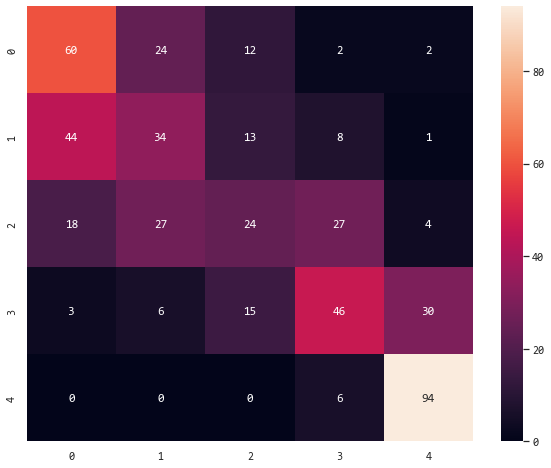

In [18]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
report = classification_report(test_labels, prediction_RF)
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
print(report)
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['0']
The actual label for this image is:  0


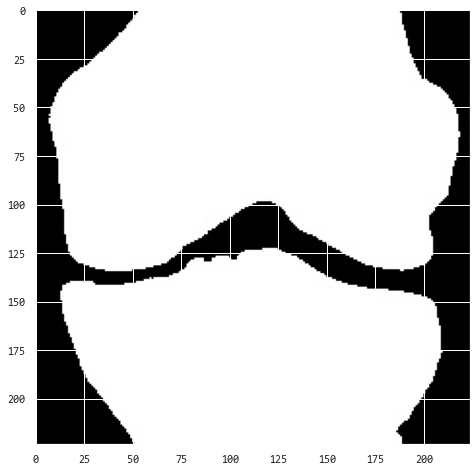

In [19]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])